<a href="https://colab.research.google.com/github/dettun/CovidDataIsrael/blob/main/Load_Research_Product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import holidays
import numpy as np
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_name = 'Residential Data - NOT Rate A - 2022 and 2023.csv'

In [ ]:
# Upload the data
def data_load(file_name):
  if ".csv" in file_name:
    return pd.read_csv(file_name, low_memory=False)
  elif ".xlsx" in file_name:
    return pd.read_excel(file_name)

In [ ]:
data = data_load(file_name)

In [ ]:
data.head()

,Ami Meter Id,Date,Channel,Flow Direction,Service Location Number,Service Map Location,Rate,Substation,Feeder,Zip Code,...,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00,Technology
0,RU10038B,2024-01-01,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,5.313,2.688,3.744,1.176,0.939,2.685,2.169,1.935,0.825,Solar; ASHP
1,RU10038B,2024-01-01,2,R,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,Solar; ASHP
2,RU10038B,2024-01-02,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,0.849,0.651,0.675,0.465,0.651,2.322,0.996,0.714,2.301,Solar; ASHP
3,RU10038B,2024-01-02,2,R,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,0.150,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,Solar; ASHP
4,RU10038B,2024-01-03,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,2.820,0.444,0.687,0.591,0.684,0.663,2.448,2.022,0.762,Solar; ASHP


In [ ]:
def is_valid_time_format(string):
   # Regular expression for "hh:mm any_separator hh:mm"
   pattern = r"^\d{2}:\d{2}\s*.\s*\d{2}:\d{2}$"
   return bool(re.match(pattern, string))

In [ ]:
# Define Season and Weekday
def get_season(date):
  year = date.year
  seasons = [('winter', pd.Timestamp(year=year, month=12, day=1)),
              ('spring', pd.Timestamp(year=year, month=3, day=1)),
              ('summer', pd.Timestamp(year=year, month=6, day=1)),
              ('autumn', pd.Timestamp(year=year, month=10, day=1))]
  for season, start_date in reversed(seasons):
      if date >= start_date:
          return season
  return 'winter'

    # Helper function to determine day category
def get_day_category(date):
  us_holidays = holidays.UnitedStates()
  if date.dayofweek >= 5 or date in us_holidays:
      return 'Weekend'
  else:
      return 'Weekday'

In [ ]:
# Apply season and day category
    data['Season'] = data['Date'].apply(get_season)
    data['Day_Category'] = data['Date'].apply(get_day_category)

In [ ]:
# Pre process for the customer type - change to datetype, melt, split hours to start and end, drop start hour,
def preprocess_data(data, var_name = 'Hour Ending', value_name = 'Flow', technology = 'Technology'):
    # Convert 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day


    # Melt the data
    cols = [x[x.find('-')+1:] for x in data.columns if  is_valid_time_format(x)]

    data.columns = [x[x.find('-')+1:] if is_valid_time_format(x) else x  for x in data.columns]
    df = pd.melt(data, id_vars=[x for x in data.columns if x not in cols],
                 var_name=var_name, value_name=value_name)

    # Split 'Hour' into 'Hour Starting' and 'Hour Ending'


    # Drop the 'Hour' column
    df_melted = df.drop(columns=[var_name])

    # Create dummy variables for Technology column if specified
    if technology is not None:
        tech_dummies = df_melted[technology].str.replace(" ","").str.get_dummies(sep=';')
        df_melted = pd.concat([df_melted, tech_dummies], axis=1).drop(columns=[technology])

    return df_melted

In [ ]:
# Run Pre-Process Data
df_melted = preprocess_data(data)

In [ ]:
df_melted.head()

,Ami Meter Id,Date,Channel,Flow Direction,Service Location Number,Service Map Location,Rate,Substation,Feeder,Zip Code,...,Day,Season,Day_Category,Flow,Hour Starting,Hour Ending,ASHP,BatteryStorage,EV,Solar
0,RU10038B,2024-01-01,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,1,winter,Weekend,0.609,00:00,01:00,1,0,0,1
1,RU10038B,2024-01-01,2,R,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,1,winter,Weekend,0.000,00:00,01:00,1,0,0,1
2,RU10038B,2024-01-02,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,2,winter,Weekday,0.729,00:00,01:00,1,0,0,1
3,RU10038B,2024-01-02,2,R,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,2,winter,Weekday,0.000,00:00,01:00,1,0,0,1
4,RU10038B,2024-01-03,1,F,54356,1951-08-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,3,winter,Weekday,2.610,00:00,01:00,1,0,0,1


In [ ]:
# Slicing of the data - Choose forward/reverse flow, choose year, choose rate type
def slice_melted_data(melted_data, slicers = {}):
    for key in slicers.keys():
        l=slicers[key]
        if type(l) != list:
            l=list()
            l.append(slicers[key])
        melted_data=melted_data.loc[melted_data[key].isin(l)]

    return melted_data

In [ ]:
slicers = {'Year':[2023],'EV':[1], 'Solar':[1], 'Flow Direction':['F']}

In [ ]:
melted_data = slice_melted_data(df_melted, slicers)

In [ ]:
melted_data.head()

,Ami Meter Id,Date,Channel,Flow Direction,Service Location Number,Service Map Location,Rate,Substation,Feeder,Zip Code,...,Day,Season,Day_Category,Flow,Hour Starting,Hour Ending,ASHP,BatteryStorage,EV,Solar
2410,RU10108B,2024-01-01,1,F,54022,1976-05-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,1,winter,Weekend,2.133000,00:00,01:00,1,0,1,1
2412,RU10108B,2024-01-02,1,F,54022,1976-05-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,2,winter,Weekday,2.194829,00:00,01:00,1,0,1,1
2414,RU10108B,2024-01-03,1,F,54022,1976-05-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,3,winter,Weekday,3.387000,00:00,01:00,1,0,1,1
2416,RU10108B,2024-01-04,1,F,54022,1976-05-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,4,winter,Weekday,3.411000,00:00,01:00,1,0,1,1
2418,RU10108B,2024-01-05,1,F,54022,1976-05-01 00:00:00,TOU A Resi Buyback On-Peak,NaN,NaN,2478,...,5,winter,Weekday,2.427000,00:00,01:00,1,0,1,1


In [ ]:
melted_data['Solar'].unique()

array([1, 0])

In [ ]:
melted_data.columns

Index(['Ami Meter Id', 'Date', 'Channel', 'Flow Direction',
       'Service Location Number', 'Service Map Location', 'Rate', 'Substation',
       'Feeder', 'Zip Code', 'Meter Type', 'Year', 'Month', 'Day', 'Season',
       'Day_Category', 'Flow', 'Hour Starting', 'Hour Ending', 'ASHP',
       'BatteryStorage', 'EV', 'Solar'],
      dtype='object')

In [ ]:
# Count the number of customers there are in this rate class
data['Ami Meter Id'].nunique()

295

In [ ]:
def aggregate_hourly_data(data):
    # Separate consumption (F) and production (R) data
    consumption_data = data[data['Flow Direction'] == 'F'].rename(columns={'Flow': 'Consumption'})
    production_data = data[data['Flow Direction'] == 'R'].rename(columns={'Flow': 'Production'})

    # Group by 'Date' and 'Hour Ending' to calculate total and average consumption
    consumption_agg = consumption_data.groupby(['Date', 'Hour Ending']).agg({
        'Consumption': ['sum', 'mean']
    }).reset_index()

    # Group by 'Date' and 'Hour Ending' to calculate total and average production
    production_agg = production_data.groupby(['Date', 'Hour Ending']).agg({
        'Production': ['sum', 'mean']
    }).reset_index()

    # Flatten column names after aggregation
    consumption_agg.columns = ['Date', 'Hour Ending', 'Total Consumption', 'Avg Consumption per Customer']
    production_agg.columns = ['Date', 'Hour Ending', 'Total Production', 'Avg Production per Customer']

    # Merge consumption and production data on 'Date' and 'Hour Ending'
    combined_agg = pd.merge(consumption_agg, production_agg, on=['Date', 'Hour Ending'], how='outer')

    # Fill any NaN values with 0 (in case of missing data for certain hours)
    combined_agg = combined_agg.fillna(0)

    return combined_agg

In [ ]:
# Run the aggregation function on the melted data
combined_8760 = aggregate_hourly_data(df_melted)

In [ ]:
def replace_zero_with_neighbor_avg(df, column='Total Consumption'):
    # Find indices where the specified column is equal to 0
    zero_indices = df.index[df[column] == 0]

    # Iterate over zero indices and replace zero values with the average of neighboring non-zero values
    for idx in zero_indices:
        # Check if the index is not at the beginning or end of the DataFrame
        if idx > 0 and idx < len(df) - 1:
            # Calculate average of neighboring non-zero values
            prev_value = df.at[idx - 1, column]
            next_value = df.at[idx + 1, column]
            # Only replace if neighboring values are non-zero
            if prev_value != 0 and next_value != 0:
                average_value = (prev_value + next_value) / 2
                # Replace zero value with the average
                df.at[idx, column] = average_value

    return df

In [ ]:
# Run the function to replace zero values in 'Total Consumption'
combined_8760 = replace_zero_with_neighbor_avg(combined_8760, column='Total Consumption')

# Display the modified DataFrame
print(combined_8760.head())

        Date Hour Ending  Total Consumption  Avg Consumption per Customer  \
0 2024-01-01       01:00            330.982                      1.248989   
1 2024-01-01       02:00            315.294                      1.189789   
2 2024-01-01       03:00            290.950                      1.097925   
3 2024-01-01       04:00            298.380                      1.125962   
4 2024-01-01       05:00            297.533                      1.122766   

   Total Production  Avg Production per Customer  Season Day_Category  Month  
0               0.0                          0.0  winter      Weekend      1  
1               0.0                          0.0  winter      Weekend      1  
2               0.0                          0.0  winter      Weekend      1  
3               0.0                          0.0  winter      Weekend      1  
4               0.0                          0.0  winter      Weekend      1  


In [ ]:
# Export the 8760 results to CSV files
combined_8760.to_csv('combined_8760.csv', index=False)

In [ ]:
def create_visualizations_and_tables(df):
    # Helper function to determine season
    def get_season(date):
        year = date.year
        seasons = [('winter', pd.Timestamp(year=year, month=12, day=1)),
                   ('spring', pd.Timestamp(year=year, month=3, day=1)),
                   ('summer', pd.Timestamp(year=year, month=6, day=1)),
                   ('autumn', pd.Timestamp(year=year, month=10, day=1))]
        for season, start_date in reversed(seasons):
            if date >= start_date:
                return season
        return 'winter'

    # Helper function to determine day category
    def get_day_category(date):
        us_holidays = holidays.UnitedStates()
        if date.dayofweek >= 5 or date in us_holidays:
            return 'Weekend'
        else:
            return 'Weekday'

    # Apply season and day category
    df['Season'] = df['Date'].apply(get_season)
    df['Day_Category'] = df['Date'].apply(get_day_category)

    # Define color gradients for background shading
    shades_of_grey = [mcolors.to_hex((1 - i/364 * 0.6 - 0.2, 1 - i/364 * 0.6 - 0.2, 1 - i/364 * 0.6 - 0.2)) for i in range(365)]

    # 1. Total consumption per day with seasonal averages
    piv_total = df.pivot_table(index='Date', columns='Hour Ending', values='Total Consumption')
    piv_total_mean = df.groupby('Hour Ending')['Total Consumption'].mean()
    piv_total_seasons = df.groupby(['Season', 'Hour Ending'])['Total Consumption'].mean().unstack(0)

    fig, ax = plt.subplots(figsize=(12, 6))
    piv_total.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)
    piv_total_mean.plot(ax=ax, color='k', linestyle='--', linewidth=2)
    piv_total_seasons.plot(ax=ax, color=['tab:blue', 'tab:red', 'tab:green', 'tab:orange'], linestyle='--', linewidth=2)
    ax.set_xlabel('Hour')
    ax.set_ylabel('KWh')
    ax.set_title('Total Consumption Per Hour with Seasonal Averages')
    ax.grid()
    plt.show()

    # 2. Total consumption with weekday/weekend averages
    piv_total_daytype = df.groupby(['Day_Category', 'Hour Ending'])['Total Consumption'].mean().unstack(0)

    fig, ax = plt.subplots(figsize=(12, 6))
    piv_total.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)
    piv_total_mean.plot(ax=ax, color='k', linestyle='--', linewidth=2)
    piv_total_daytype.plot(ax=ax, color=['tab:blue', 'tab:red'], linestyle='--', linewidth=2)
    ax.set_xlabel('Hour')
    ax.set_ylabel('KWh')
    ax.set_title('Total Consumption Per Hour (Weekday/Weekend)')
    ax.grid()
    plt.show()

    # 3. Total production per day with seasonal averages
    piv_prod = df.pivot_table(index='Date', columns='Hour Ending', values='Total Production')
    piv_prod_mean = df.groupby('Hour Ending')['Total Production'].mean()
    piv_prod_seasons = df.groupby(['Season', 'Hour Ending'])['Total Production'].mean().unstack(0)

    fig, ax = plt.subplots(figsize=(12, 6))
    piv_prod.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)
    piv_prod_mean.plot(ax=ax, color='k', linestyle='--', linewidth=2)
    piv_prod_seasons.plot(ax=ax, color=['tab:blue', 'tab:red', 'tab:green', 'tab:orange'], linestyle='--', linewidth=2)
    ax.set_xlabel('Hour')
    ax.set_ylabel('KWh')
    ax.set_title('Total Production Per Hour with Seasonal Averages')
    ax.grid()
    plt.show()

    # 4. Total production with weekday/weekend averages
    piv_prod_daytype = df.groupby(['Day_Category', 'Hour Ending'])['Total Production'].mean().unstack(0)

    fig, ax = plt.subplots(figsize=(12, 6))
    piv_prod.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)
    piv_prod_mean.plot(ax=ax, color='k', linestyle='--', linewidth=2)
    piv_prod_daytype.plot(ax=ax, color=['tab:blue', 'tab:red'], linestyle='--', linewidth=2)
    ax.set_xlabel('Hour')
    ax.set_ylabel('KWh')
    ax.set_title('Total Production Per Hour (Weekday/Weekend)')
    ax.grid()
    plt.show()

    # 5-8. Same for average consumption and production per customer per hour
    piv_avg_cons = df.pivot_table(index='Date', columns='Hour Ending', values='Avg Consumption per Customer')
    piv_avg_prod = df.pivot_table(index='Date', columns='Hour Ending', values='Avg Production per Customer')

    # 9. Monthly maximum consumption and peak hours
    df['Month'] = df['Date'].dt.month
    max_consumption_rows = df.loc[df.groupby(df['Date'].dt.month)['Total Consumption'].idxmax()]
    muni_consumption_per_month = df.groupby(df['Date'].dt.month)['Total Consumption'].sum().reset_index()
    muni_consumption_per_month.columns = ['Month', 'Total Consumption']

    max_consumption_rows['Month'] = max_consumption_rows['Date'].dt.month
    max_consumption_rows = max_consumption_rows[['Month', 'Date', 'Hour Ending', 'Total Consumption']]
    max_consumption_rows.columns = ['Month', 'Date', 'End Hour', 'Peak Consumption']

    # Merge total consumption and peak consumption details
    df_monthly = pd.merge(max_consumption_rows, muni_consumption_per_month, on='Month')

    print("Monthly Maximum Consumption and Peak Hours:")
    print(df_monthly)

    return df_monthly

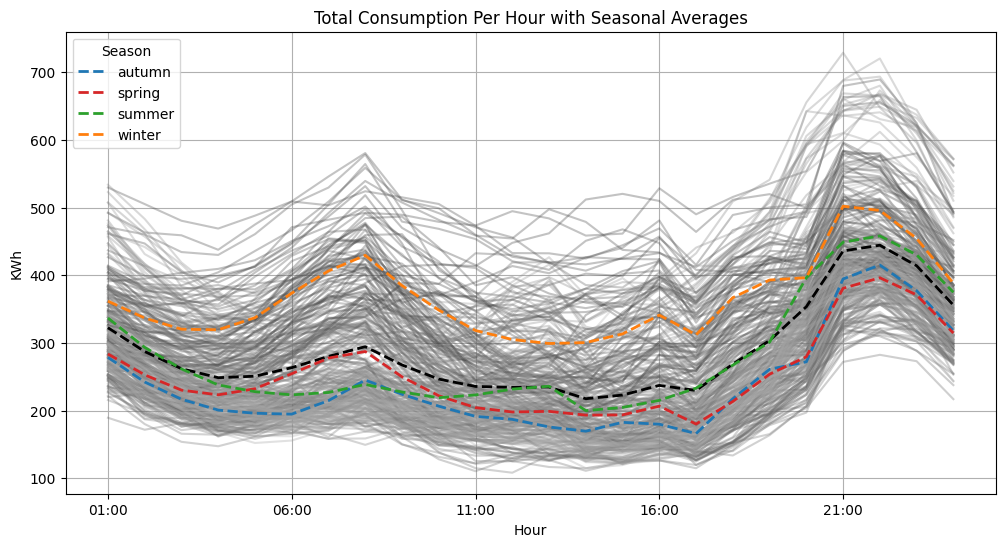

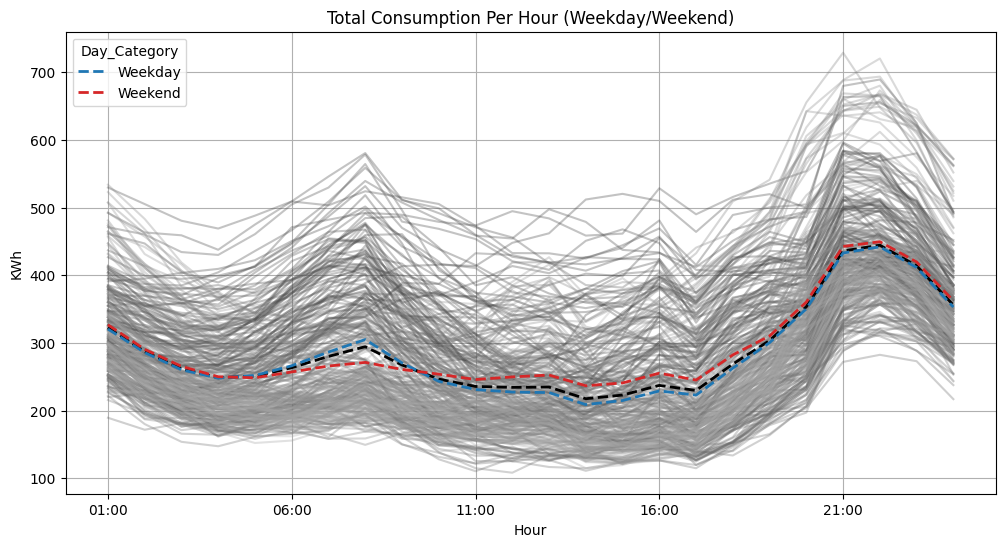

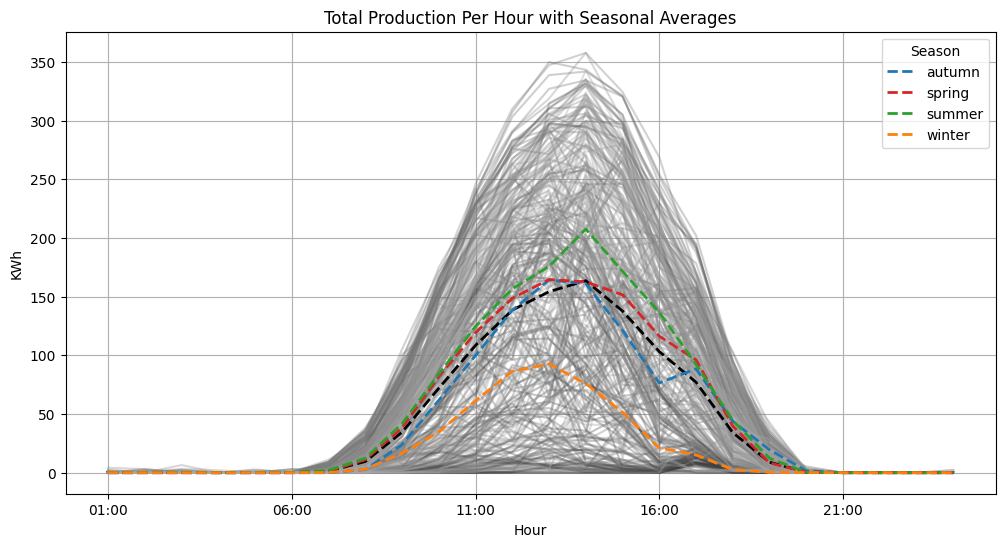

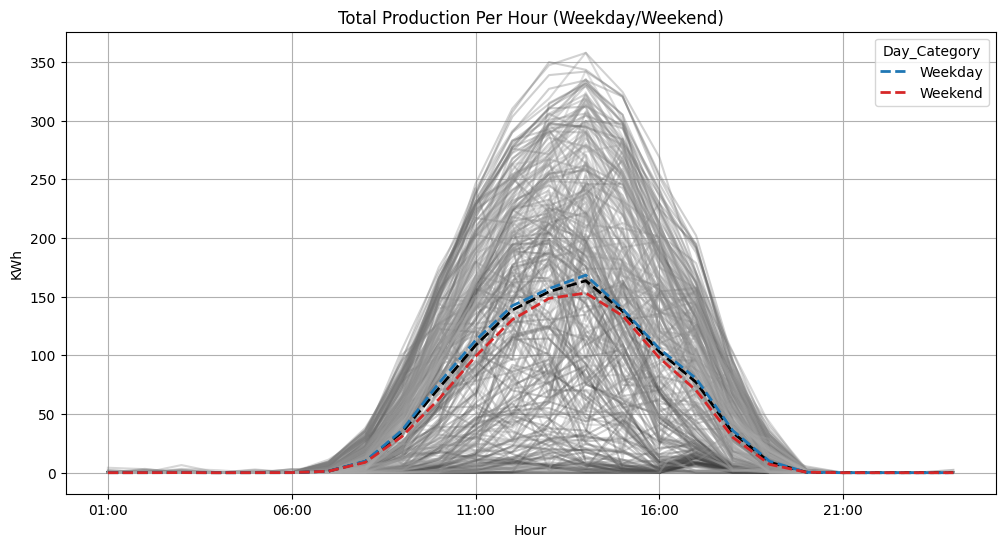

Monthly Maximum Consumption and Peak Hours:
   Month       Date End Hour  Peak Consumption  Total Consumption
0      1 2024-01-17    22:00        689.478000      295401.142290
1      2 2024-02-14    21:00        577.902000      233001.202124
2      3 2024-03-26    22:00        512.188000      219067.900552
3      4 2024-04-04    22:00        538.156231      175582.263517
4      5 2024-05-22    22:00        504.931284      160429.051801
5      6 2024-06-20    21:00        729.051782      193026.434766
6      7 2024-07-16    22:00        720.481000      244803.886995
7      8 2024-08-03    21:00        661.104000      208125.115803
8      9 2024-09-15    22:00        540.556000      173335.041271
9     10 2024-10-13    21:00        469.251000       74486.028133


In [ ]:
df_monthly = create_visualizations_and_tables(combined_8760)


This is a combination of all possible years, rates, and technology types


In [ ]:
import pandas as pd

def create_combination_dataframes(df, year_col='Date', rate_col='Rate', tech_col='Technology'):
    # Extract unique years, rates, and technology types
    years = df[year_col].dt.year.unique()
    rates = df[rate_col].unique()
    technologies = df[tech_col].unique()

    # Initialize a dictionary to store DataFrames for each combination
    combination_dfs = {}

    # Loop through each combination of year, rate, and technology
    for year in years:
        for rate in rates:
            for tech in technologies:
                # Filter the DataFrame for the current combination
                filtered_df = df[(df[year_col].dt.year == year) &
                                 (df[rate_col] == rate) &
                                 (df[tech_col].str.contains(tech, na=False))]

                # Store the filtered DataFrame in the dictionary if not empty
                if not filtered_df.empty:
                    # Create a unique key for this combination
                    key = f"{year}_{rate}_{tech}"
                    combination_dfs[key] = filtered_df

    return combination_dfs

Specific Rate Analysis

TOU Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import holidays

def get_season(date):
    year = date.year
    seasons = [('Summer', pd.Timestamp(year=year, month=6, day=1)),
               ('Non-Summer', pd.Timestamp(year=year, month=10, day=1))]
    for season, start_date in reversed(seasons):
        if date >= start_date:
            return season
    return 'Non-Summer'

def get_day_category(date):
    us_holidays = holidays.UnitedStates()
    if date.dayofweek >= 5 or date in us_holidays:
        return 'Weekend'
    else:
        return 'Weekday'

In [ ]:
def prepare_TOU_data(df):
    # Apply season and day category
    df['Season'] = df['Date'].apply(get_season)
    df['Day_Category'] = df['Date'].apply(get_day_category)

    # Define summer and non-summer date ranges
    summer_start_date = pd.to_datetime('2023-06-01')
    summer_end_date = pd.to_datetime('2023-09-30')

    # Filter the DataFrame for summer and non-summer data
    df_summer = df[(df['Date'] >= summer_start_date) & (df['Date'] <= summer_end_date)]
    df_non_summer = df[~((df['Date'] >= summer_start_date) & (df['Date'] <= summer_end_date))]

    return df_summer, df_non_summer

In [ ]:
def visualize_TOU_data(df, title, peak_start_hour, peak_end_hour, ylabel='KWh'):
    shades_of_grey = [mcolors.to_hex((1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2)) for i in range(365)]

    # Pivot table and calculate means for the plot
    piv = df.pivot_table(index='Date', columns='Hour Ending', values='Total Consumption')
    piv_mean = df.groupby('Hour Ending')['Total Consumption'].mean()
    piv_daytype = df.groupby(['Day_Category', 'Hour Ending'])['Total Consumption'].mean().unstack(0)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot consumption data
    piv.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)
    piv_mean.plot(ax=ax, color='k', ls='--', lw=2)
    piv_daytype.plot(ax=ax, color=['tab:blue', 'tab:red'], ls='--', lw=2)

    # Highlight peak demand hours
    ax.fill_between(np.arange(peak_start_hour, peak_end_hour + 1), 0, max(piv_mean.max(), 200), color='lightyellow')

    # Customize the plot
    ax.grid()
    ax.set_xlabel('Hour')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

In [ ]:
def calculate_TOU_cost(df):
    # Define tariff rates (in $/kWh) for summer and non-summer periods, and on-peak and off-peak hours
    summer_on_peak_rate = 0.47712
    summer_off_peak_rate = 0.1382
    non_summer_on_peak_rate = 0.3172
    non_summer_off_peak_rate = 0.14336

    # Define on-peak and off-peak hours for summer and non-summer periods
    summer_on_peak_hours = range(13, 20)  # 1pm to 7pm inclusive
    non_summer_on_peak_hours = range(16, 21)  # 4pm to 8pm inclusive

    # Add a column to indicate whether it's on-peak or off-peak
    df['Peak_Type'] = np.where((df['Season'] == 'Summer') & (df['Hour Ending'].isin(summer_on_peak_hours)), 'On-Peak',
                               np.where((df['Season'] == 'Non-Summer') & (df['Hour Ending'].isin(non_summer_on_peak_hours)), 'On-Peak', 'Off-Peak'))

    # Calculate the cost per kWh for each consumption record
    df['Cost_per_kWh'] = np.where((df['Peak_Type'] == 'On-Peak') & (df['Season'] == 'Summer'), summer_on_peak_rate,
                                  np.where((df['Peak_Type'] == 'On-Peak') & (df['Season'] == 'Non-Summer'), non_summer_on_peak_rate,
                                           np.where((df['Peak_Type'] == 'Off-Peak') & (df['Season'] == 'Summer'), summer_off_peak_rate,
                                                    non_summer_off_peak_rate)))

    # Calculate the cost for each consumption record
    df['Cost'] = df['Total Consumption'] * df['Cost_per_kWh']

    return df

In [ ]:
def TOU_analysis(df):
    # Prepare data
    df_summer, df_non_summer = prepare_TOU_data(df)

    # Calculate costs
    df = calculate_TOU_cost(df)

    # Visualize summer TOU
    visualize_TOU_data(df_summer,
                       title='TOU Daily Consumption Per Hour (Weekday/Weekend) Summer (June 1 - Sep 30)',
                       peak_start_hour=13, peak_end_hour=19)

    # Visualize non-summer TOU
    visualize_TOU_data(df_non_summer,
                       title='TOU Daily Consumption Per Hour (Weekday/Weekend) Non-Summer (Oct 1 - May 30)',
                       peak_start_hour=16, peak_end_hour=20)

    return df

TypeError: no numeric data to plot

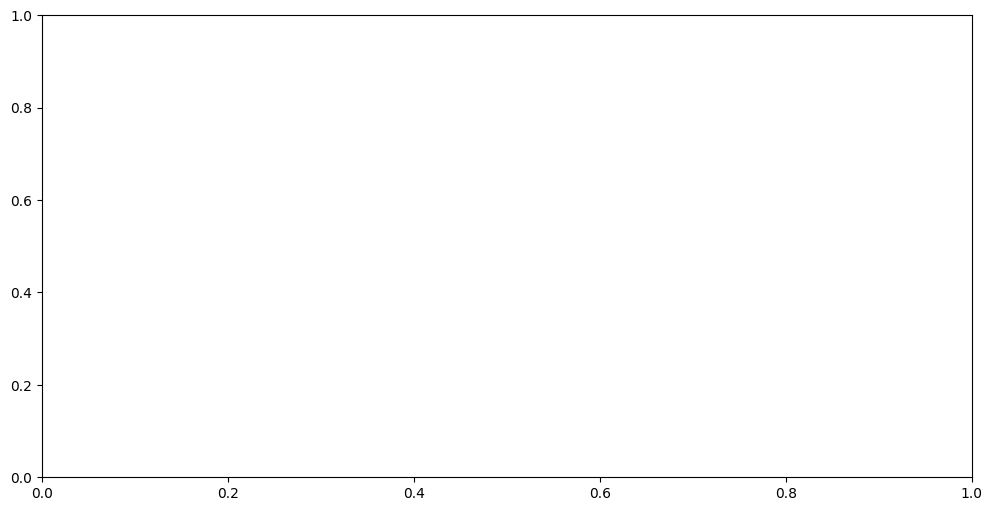

In [ ]:
combined_8760 = TOU_analysis(combined_8760)

In [ ]:
# Filter out certain rates based on rate categories
df_TOU = df_melted[(df_melted['Rate'] == 'TOU A Resi Buyback On-Peak') |
                         (df_melted['Rate'] == 'TOU A Residential On-Peak') ]

In [ ]:
# Count the number of customers there are in this rate class
df_1['Ami Meter Id'].nunique()

144

In [ ]:
# Group by 'Date' and 'Hour Ending', then sum the 'Consumption' values to create the 8760 load data
df_TOU = df_TOU.groupby(['Date', 'Hour Ending']).agg({'Consumption': 'sum'}).reset_index()

In [ ]:
df_TOU['Date'] = pd.to_datetime(df_TOU['Date'])

In [ ]:
df_TOU['Season'] = df_TOU['Date'].apply(get_season)

In [ ]:
# Define the date range for summer (June 1 to September 30)
summer_start_date = pd.to_datetime('2023-06-01')
summer_end_date = pd.to_datetime('2023-09-30')

# Filter the DataFrame for summer data
df_TOU_summer = df_TOU[(df_TOU['Date'] >= summer_start_date) & (df_TOU['Date'] <= summer_end_date)]

# Filter the DataFrame for non-summer data
df_TOU_non_summer = df_TOU[~((df_TOU['Date'] >= summer_start_date) & (df_TOU['Date'] <= summer_end_date))]

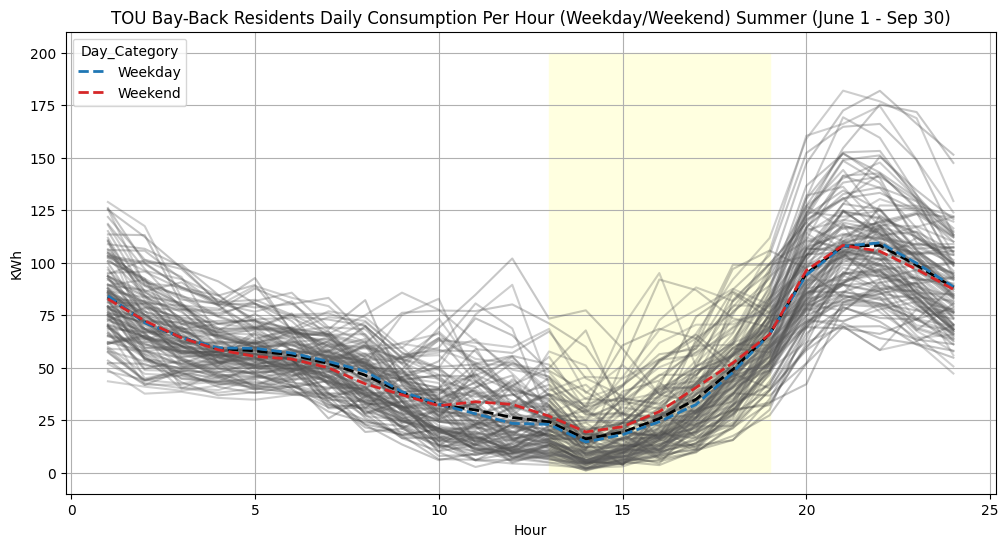

In [ ]:
# Define the hour range for peak-demand hours (between 1pm and 7pm)
peak_start_hour = 13
peak_end_hour = 19

# Create shades of grey
shades_of_grey = [mcolors.to_hex((1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2)) for i in range(365)]

# Pivot table
piv = df_TOU_summer.pivot_table(index='Date', columns='End Hour', values='Consumption')

# Calculate mean consumption per hour
piv_mean = df_TOU_summer.groupby('End Hour').Consumption.mean()

# Calculate mean consumption per hour for each day category
piv_daytype = df_TOU_summer.groupby(['Day_Category', 'End Hour']).Consumption.mean().unstack(0)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot consumption data
piv.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)

# Plot mean consumption
piv_mean.T.plot(ax=ax, color='k', ls='--', lw=2)

# Plot consumption for each day category
piv_daytype.plot(ax=ax, color=['tab:blue', 'tab:red'], ls='--', lw=2)

# Color the area between the dashed lines
ax.fill_between(np.arange(peak_start_hour, peak_end_hour + 1), 0, 200, color='lightyellow')

# Customize the plot
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('KWh')
ax.set_title('TOU Daily Consumption Per Hour (Weekday/Weekend) Summer (June 1 - Sep 30)')

# Show the plot
plt.show()

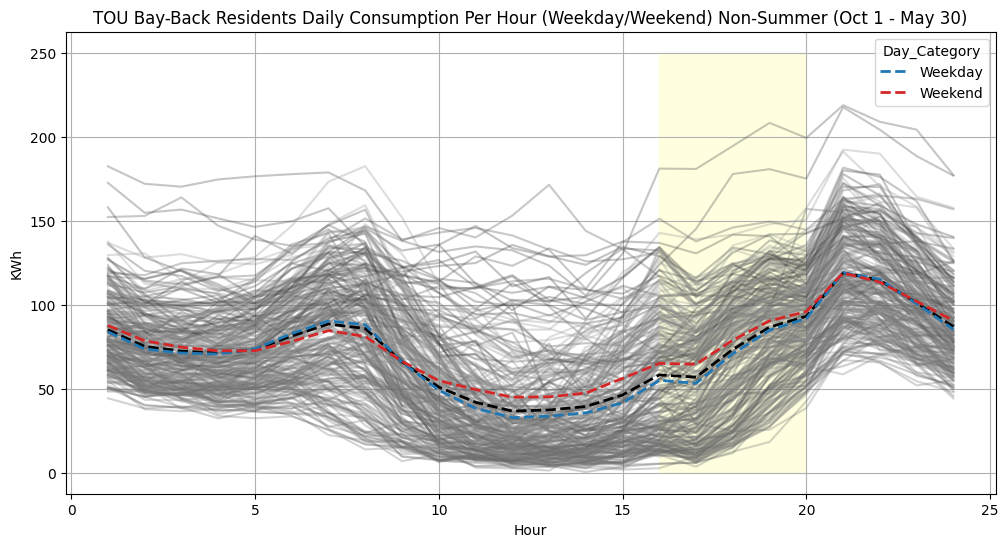

In [ ]:
# Assuming df_TOU_non_summer is your DataFrame containing summer consumption data

# Define the hour range for peak-demand hours
peak_start_hour = 16
peak_end_hour = 20

# Create shades of grey
shades_of_grey = [mcolors.to_hex((1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2, 1 - i / 364 * 0.6 - 0.2)) for i in range(365)]

# Pivot table
piv = df_TOU_non_summer.pivot_table(index='Date', columns='End Hour', values='Consumption')

# Calculate mean consumption per hour
piv_mean = df_TOU_non_summer.groupby('End Hour').Consumption.mean()

# Calculate mean consumption per hour for each day category
piv_daytype = df_TOU_non_summer.groupby(['Day_Category', 'End Hour']).Consumption.mean().unstack(0)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot consumption data
piv.T.plot(ax=ax, color=shades_of_grey[::-1], legend=False, alpha=0.3)

# Plot mean consumption
piv_mean.T.plot(ax=ax, color='k', ls='--', lw=2)

# Plot consumption for each day category
piv_daytype.plot(ax=ax, color=['tab:blue', 'tab:red'], ls='--', lw=2)

# Color the area between the dashed lines
ax.fill_between(np.arange(peak_start_hour, peak_end_hour + 1), 0, 250, color='lightyellow')

# Customize the plot
ax.grid()
ax.set_xlabel('Hour')
ax.set_ylabel('KWh')
ax.set_title('TOU Daily Consumption Per Hour (Weekday/Weekend) Non-Summer (Oct 1 - May 30)')

# Show the plot
plt.show()

In [ ]:
# Define tariff rates (in $/kWh) for summer and non-summer periods, and on-peak and off-peak hours
summer_on_peak_rate = 0.47712
summer_off_peak_rate = 0.1382
non_summer_on_peak_rate = 0.3172
non_summer_off_peak_rate = 0.14336

In [ ]:
# Define on-peak and off-peak hours for summer and non-summer periods
summer_on_peak_hours = range(14, 20)  # 1pm to 7pm inclusive
non_summer_on_peak_hours = range(17, 21)  # 4pm to 8pm inclusive

In [ ]:
# Add a column to indicate whether it's on-peak or off-peak
df_TOU['Peak_Type'] = np.where((df_TOU['Season'] == 'Summer') & (df_TOU['End Hour'].isin(summer_on_peak_hours)), 'On-Peak',
                             np.where((df_TOU['Season'] == 'Non-Summer') & (df_TOU['End Hour'].isin(non_summer_on_peak_hours)), 'On-Peak', 'Off-Peak'))

In [ ]:
# Calculate the cost per kWh for each consumption record
df_TOU['Cost_per_kWh'] = np.where((df_TOU['Peak_Type'] == 'On-Peak') & (df_TOU['Season'] == 'Summer'), summer_on_peak_rate,
                                np.where((df_TOU['Peak_Type'] == 'On-Peak') & (df_TOU['Season'] == 'Non-Summer'), non_summer_on_peak_rate,
                                         np.where((df_TOU['Peak_Type'] == 'Off-Peak') & (df_TOU['Season'] == 'Summer'), summer_off_peak_rate,
                                                  non_summer_off_peak_rate)))

In [ ]:
# Calculate the cost for each consumption record
df_TOU['Cost'] = df_TOU['Consumption'] * df_TOU['Cost_per_kWh']

Average Customer Curves - need to revise code

In [ ]:
# Initialize dictionaries to hold sum and count of data for each hour
hourly_sum_residential = [0] * 24
hourly_count_residential = [0] * 24

In [ ]:
# Define a regex pattern to match valid time ranges (e.g., "02:00-03:00")
valid_time_pattern = re.compile(r'^\d{2}:\d{2}-\d{2}:\d{2}$')

In [ ]:
# Process each file for Residential Rate A data in chunks
for path in monthly_data_paths:
    for chunk in pd.read_csv(path, chunksize=10000, low_memory=False):
        # Filter data for the year 2023 and 'F' flow direction
        chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce')
        chunk = chunk[(chunk['Date'].dt.year == 2023) & (chunk['Flow Direction'] == 'F')]

        # Melt data to convert from wide to long format
        melted_chunk = chunk.melt(id_vars=['Date', 'Flow Direction'], var_name='Time', value_name='Usage')

        # Ensure the 'Time' column has valid entries
        melted_chunk = melted_chunk[melted_chunk['Time'].str.match(valid_time_pattern, na=False)]

        # Extract the starting hour from the range (e.g., "02:00" from "02:00-03:00")
        melted_chunk['Hour'] = melted_chunk['Time'].str.split('-').str[0].str[:2].astype(int)

        # Remove invalid entries
        melted_chunk.dropna(subset=['Usage'], inplace=True)

        # Accumulate sum and count for each hour
        for hour in range(24):
            hour_data = melted_chunk[melted_chunk['Hour'] == hour]['Usage']
            hourly_sum_residential[hour] += hour_data.sum()
            hourly_count_residential[hour] += len(hour_data)

In [ ]:
# Calculate the final hourly average for Residential Rate A
hourly_avg_residential = [hourly_sum_residential[i] / hourly_count_residential[i] if hourly_count_residential[i] > 0 else 0 for i in range(24)]

In [ ]:
# Define a regex pattern to match valid time ranges (e.g., "02:00-03:00")
valid_time_pattern = re.compile(r'^\d{2}:\d{2}-\d{2}:\d{2}$')

In [ ]:
# Process the TOU data for 'TOU A Resi Buyback On-Peak' and 'TOU A Residential On-Peak' similarly
tou_data_path = 'Residential Data - NOT Rate A - 2022 and 2023.csv'
hourly_sum_tou_buyback = [0] * 24
hourly_count_tou_buyback = [0] * 24
hourly_sum_tou_no_buyback = [0] * 24
hourly_count_tou_no_buyback = [0] * 24

In [ ]:
# Process the TOU data for 'TOU A Resi Buyback On-Peak' and 'TOU A Residential On-Peak'
for chunk in pd.read_csv(tou_data_path, chunksize=10000, low_memory=False):
    # Filter data for the year 2023, 'F' flow direction, and the relevant TOU rates
    chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce')
    chunk = chunk[(chunk['Date'].dt.year == 2023) &
                  (chunk['Flow Direction'] == 'F') &
                  (chunk['Rate'].isin(['TOU A Resi Buyback On-Peak', 'TOU A Residential On-Peak']))]

    # Melt and process the data
    melted_chunk = chunk.melt(id_vars=['Date', 'Flow Direction', 'Rate'], var_name='Time', value_name='Usage')

    # Ensure the 'Time' column contains valid entries only
    melted_chunk = melted_chunk[melted_chunk['Time'].str.match(valid_time_pattern, na=False)]

    # Extract the starting hour from the range (e.g., "02:00" from "02:00-03:00") and convert to integer
    melted_chunk['Hour'] = pd.to_numeric(melted_chunk['Time'].str.split('-').str[0].str[:2], errors='coerce')

    # Drop any rows where 'Hour' could not be converted to a valid numeric value
    melted_chunk.dropna(subset=['Hour', 'Usage'], inplace=True)
    melted_chunk['Hour'] = melted_chunk['Hour'].astype(int)

    # Separate processing for the two TOU rates
    for hour in range(24):
        # For TOU with Buyback
        hour_data_buyback = melted_chunk[(melted_chunk['Hour'] == hour) & (melted_chunk['Rate'] == 'TOU A Resi Buyback On-Peak')]['Usage']
        hourly_sum_tou_buyback[hour] += hour_data_buyback.sum()
        hourly_count_tou_buyback[hour] += len(hour_data_buyback)

        # For TOU without Buyback
        hour_data_no_buyback = melted_chunk[(melted_chunk['Hour'] == hour) & (melted_chunk['Rate'] == 'TOU A Residential On-Peak')]['Usage']
        hourly_sum_tou_no_buyback[hour] += hour_data_no_buyback.sum()
        hourly_count_tou_no_buyback[hour] += len(hour_data_no_buyback)

In [ ]:
# Calculate the final hourly averages
hourly_avg_tou_buyback = [hourly_sum_tou_buyback[i] / hourly_count_tou_buyback[i] if hourly_count_tou_buyback[i] > 0 else 0 for i in range(24)]
hourly_avg_tou_no_buyback = [hourly_sum_tou_no_buyback[i] / hourly_count_tou_no_buyback[i] if hourly_count_tou_no_buyback[i] > 0 else 0 for i in range(24)]

In [ ]:
# Combine the hourly averages into a DataFrame
hourly_averages = pd.DataFrame({
    'Hour': range(24),
    'Residential Rate A': hourly_avg_residential,
    'TOU With Buyback': hourly_avg_tou_buyback,
    'TOU Without Buyback': hourly_avg_tou_no_buyback
})

# Display the hourly averages
hourly_averages

,Hour,Residential Rate A,TOU With Buyback,TOU Without Buyback
0,0,0.617122,1.322447,0.986844
1,1,0.559299,1.156982,0.890074
2,2,0.527711,1.088805,0.844766
3,3,0.512114,1.050067,0.893479
4,4,0.507949,1.066290,0.908297
5,5,0.527026,1.139472,0.913351
6,6,0.589955,1.192450,0.935004
7,7,0.666353,1.135479,1.011698
8,8,0.693863,0.885556,0.993081
9,9,0.715386,0.699413,0.990634


In [ ]:
import pandas as pd

# Generate a complete hourly datetime index for the year 2023
datetime_index = pd.date_range(start='2023-01-01 00:00', end='2023-12-31 23:00', freq='H')

# Create a DataFrame with this datetime index
average_hourly_consumption_df = pd.DataFrame({'Datetime': datetime_index})

# Assuming 'hourly_sum_residential', 'hourly_count_residential', 'hourly_sum_tou_buyback',
# 'hourly_count_tou_buyback', 'hourly_sum_tou_no_buyback', and 'hourly_count_tou_no_buyback'
# were calculated previously during data processing, calculate the hourly averages

# Add the average consumption data for each hour
average_hourly_consumption_df['Residential Rate A'] = [
    hourly_sum_residential[hour % 24] / hourly_count_residential[hour % 24] if hourly_count_residential[hour % 24] > 0 else 0
    for hour in range(len(datetime_index))
]

average_hourly_consumption_df['TOU With Buyback'] = [
    hourly_sum_tou_buyback[hour % 24] / hourly_count_tou_buyback[hour % 24] if hourly_count_tou_buyback[hour % 24] > 0 else 0
    for hour in range(len(datetime_index))
]

average_hourly_consumption_df['TOU Without Buyback'] = [
    hourly_sum_tou_no_buyback[hour % 24] / hourly_count_tou_no_buyback[hour % 24] if hourly_count_tou_no_buyback[hour % 24] > 0 else 0
    for hour in range(len(datetime_index))
]

# Save this dataset to an Excel file
average_hourly_consumption_df.to_excel('average_hourly_consumption_2023.xlsx', index=False)

print("The dataset with average hourly consumption for the entire year has been saved to 'average_hourly_consumption_2023.xlsx'.")

The dataset with average hourly consumption for the entire year has been saved to 'average_hourly_consumption_2023.xlsx'.


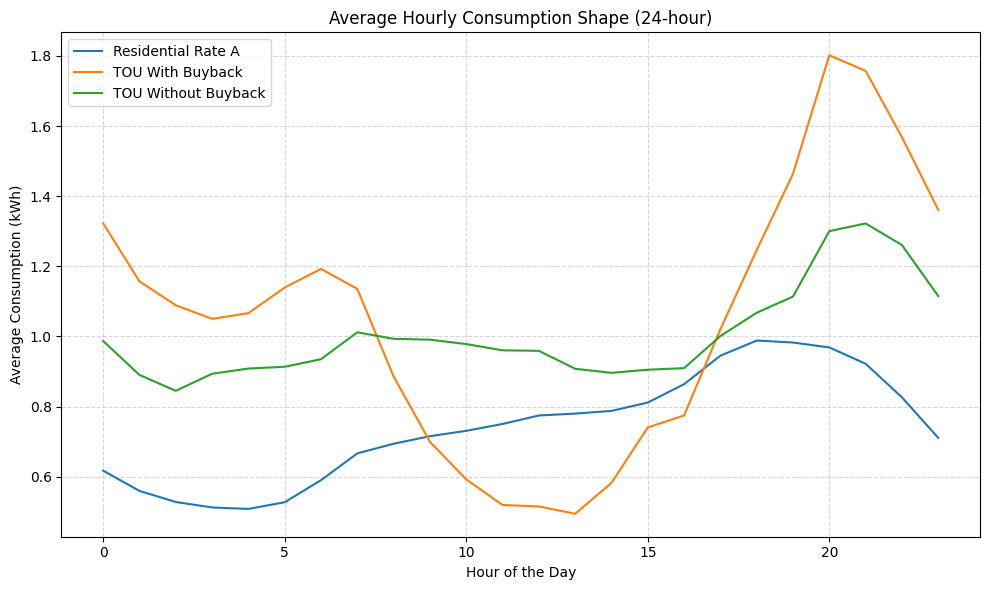

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'hourly_sum_residential', 'hourly_count_residential',
# 'hourly_sum_tou_buyback', 'hourly_count_tou_buyback',
# 'hourly_sum_tou_no_buyback', and 'hourly_count_tou_no_buyback'
# are available from previous calculations

# Calculate the average consumption for each hour of the day
average_24hour_residential = [hourly_sum_residential[hour] / hourly_count_residential[hour] if hourly_count_residential[hour] > 0 else 0 for hour in range(24)]
average_24hour_tou_buyback = [hourly_sum_tou_buyback[hour] / hourly_count_tou_buyback[hour] if hourly_count_tou_buyback[hour] > 0 else 0 for hour in range(24)]
average_24hour_tou_no_buyback = [hourly_sum_tou_no_buyback[hour] / hourly_count_tou_no_buyback[hour] if hourly_count_tou_no_buyback[hour] > 0 else 0 for hour in range(24)]

# Create an hour range for plotting
hours = range(24)

# Plot the average 24-hour consumption for each customer type
plt.figure(figsize=(10, 6))
plt.plot(hours, average_24hour_residential, label='Residential Rate A', linewidth=1.5)
plt.plot(hours, average_24hour_tou_buyback, label='TOU With Buyback', linewidth=1.5)
plt.plot(hours, average_24hour_tou_no_buyback, label='TOU Without Buyback', linewidth=1.5)

# Set plot title and labels
plt.title('Average Hourly Consumption Shape (24-hour)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Consumption (kWh)')
plt.legend()

# Display the grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
hourly_averages.to_excel('ahourly_averages.xlsx', index=False)